In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn

In [173]:
# build the NN model
class BSModel(nn.Module):

    def __init__(self, input_dim=2, hidden_dim1=100, hidden_dim2=50, output_dim=1):
        super(BSModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_dim2, hidden_dim2)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        out = self.relu2(out)

        out = self.fc3(out)
        out = self.relu3(out)

        out = self.fc4(out)
        out = self.relu4(out)

        out = self.fc5(out)

        return out

In [190]:
# def the parameters
sigma = 0.2
r = 0.05
K = 100
T = 1  #1year
S_inf = 1000

In [191]:
model = BSModel()

In [176]:
x = torch.tensor([[1, 2], [3,4]])

In [177]:
x[:, 0]

tensor([1, 3])

In [192]:
def bsm_loss_with_bc(model, inputs, K, S_inf, sigma, r, T):

    inputs.requires_grad = True
    V = model(inputs)
    S = inputs[:, 0].view(-1, 1)
    t = inputs[:, 1].view(-1, 1)

    # Take the derivative of V with respect to S and t
    V_S = torch.autograd.grad(V.sum(), inputs, create_graph=True, retain_graph=True)[0][:, 0]
    V_t = torch.autograd.grad(V.sum(), inputs, create_graph=True, retain_graph=True)[0][:, 1]
    V_SS = torch.autograd.grad(V_S.sum(), inputs, create_graph=True)[0][:, 0]

    pde_loss = torch.mean((V_t + 0.5 * (sigma ** 2) * (S ** 2) * V_SS + r * S * V_S - r * V) ** 2)

    # Define the boundary condition loss
    bc_loss = 0

    # Boundary condition when t goes to T, V should approximate max(S-K, 0)
    V_expiry = model(torch.hstack((S, torch.full_like(t, T))))
    call_payoff = torch.maximum(S - K, torch.zeros_like(S))
    expiry_loss = torch.mean((V_expiry - call_payoff) ** 2)

    # Boundary condition when S goes to 0, then V should go to 0
    V_zero = model(torch.hstack((torch.zeros_like(S), t)))
    zero_loss = torch.mean(V_zero ** 2)

    # Boundary condition when S goes to S_inf, V should behave as S - K * exp(-r * (T - t))
    V_inf = model(torch.hstack((torch.full_like(S, S_inf), t)))
    inf_loss = torch.mean((V_inf - (S - K * torch.exp(-r * (T - t)))) ** 2)

    bc_loss = expiry_loss + zero_loss + inf_loss

    # Combine PDE and boundary losses
    total_loss = 0.95 * pde_loss + 0.05 * bc_loss

    return total_loss


In [193]:
model.parameters

<bound method Module.parameters of BSModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=50, out_features=1, bias=True)
)>

In [194]:
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [181]:
pip install torchviz

In [182]:

from torchviz import make_dot

# Assume 'model' is your PyTorch ANN model.

# Create a dummy variable with the correct input size.
# For example, for an input size of 5, it would be:
x = torch.randn(1, 2)

# Perform a forward pass to get the output.
y = model(x)

# Use make_dot to create the graph.
dot = make_dot(y, params=dict(model.named_parameters()))

# Save the graph to a file or render it in a Jupyter Notebook.
dot.render('network_graph', format='png') # Saves the graph to a .png file.

'network_graph.png'

In [195]:
S_values = torch.linspace(0.0, 150.0, 1000).view(-1, 1)
t_values = torch.linspace(0.0, 1.0, 1000).view(-1, 1)

In [196]:


input = torch.cat((S_values, t_values), dim=1)
input.shape

torch.Size([1000, 2])

In [197]:
input[:, 0]

tensor([  0.0000,   0.1502,   0.3003,   0.4505,   0.6006,   0.7508,   0.9009,
          1.0511,   1.2012,   1.3514,   1.5015,   1.6517,   1.8018,   1.9520,
          2.1021,   2.2523,   2.4024,   2.5526,   2.7027,   2.8529,   3.0030,
          3.1532,   3.3033,   3.4535,   3.6036,   3.7538,   3.9039,   4.0541,
          4.2042,   4.3544,   4.5045,   4.6547,   4.8048,   4.9550,   5.1051,
          5.2553,   5.4054,   5.5556,   5.7057,   5.8559,   6.0060,   6.1562,
          6.3063,   6.4565,   6.6066,   6.7568,   6.9069,   7.0571,   7.2072,
          7.3574,   7.5075,   7.6577,   7.8078,   7.9580,   8.1081,   8.2583,
          8.4084,   8.5586,   8.7087,   8.8589,   9.0090,   9.1592,   9.3093,
          9.4595,   9.6096,   9.7598,   9.9099,  10.0601,  10.2102,  10.3604,
         10.5105,  10.6607,  10.8108,  10.9610,  11.1111,  11.2613,  11.4114,
         11.5616,  11.7117,  11.8619,  12.0120,  12.1622,  12.3123,  12.4625,
         12.6126,  12.7628,  12.9129,  13.0631,  13.2132,  13.36

In [198]:
for epoch in range(10001):
    optimizer.zero_grad()
    loss = bsm_loss_with_bc(model, input, K, S_inf, sigma, r, T)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 115.10641479492188
Epoch 100, Loss: 104.00088500976562
Epoch 200, Loss: 103.22900390625
Epoch 300, Loss: 101.19518280029297
Epoch 400, Loss: 98.16938781738281
Epoch 500, Loss: 96.49762725830078
Epoch 600, Loss: 94.87828063964844
Epoch 700, Loss: 95.13169860839844
Epoch 800, Loss: 91.79063415527344
Epoch 900, Loss: 89.92285919189453
Epoch 1000, Loss: 89.810546875
Epoch 1100, Loss: 82.61486053466797
Epoch 1200, Loss: 74.66326141357422
Epoch 1300, Loss: 63.98100280761719
Epoch 1400, Loss: 51.695648193359375
Epoch 1500, Loss: 39.94753646850586
Epoch 1600, Loss: 52.83534622192383
Epoch 1700, Loss: 40.57535171508789
Epoch 1800, Loss: 25.364633560180664
Epoch 1900, Loss: 41.58498001098633
Epoch 2000, Loss: 9.303372383117676
Epoch 2100, Loss: 13.702404022216797
Epoch 2200, Loss: 9.305245399475098
Epoch 2300, Loss: 1.6275341510772705
Epoch 2400, Loss: 3.3494350910186768
Epoch 2500, Loss: 2.257124423980713
Epoch 2600, Loss: 1.6679582595825195
Epoch 2700, Loss: 1.1422051191329956
E

In [199]:
S_values = torch.linspace(50.0, 150.0, 10000).view(-1, 1)
t_values = torch.linspace(0.0, 0.0, 10000).view(-1, 1)
input = torch.cat((S_values, t_values), dim=1)

In [200]:

V_pred = model(input)

<ipython-input-201-542018e98bef>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


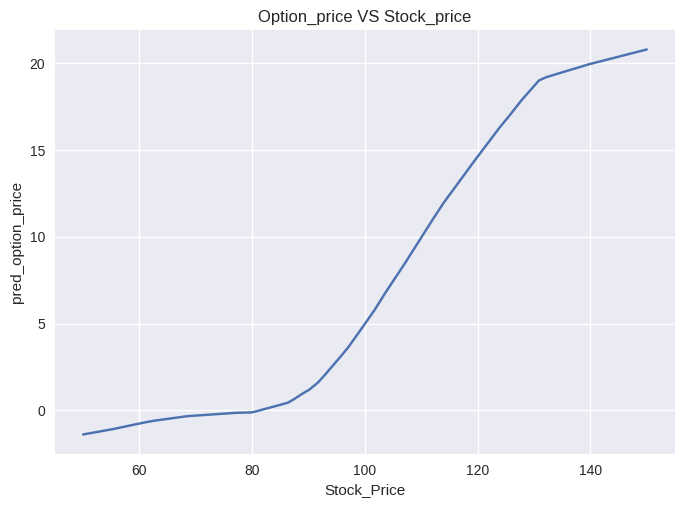

In [201]:

%matplotlib inline
plt.style.use('seaborn')
plt.plot(S_values.numpy(), V_pred.detach().numpy())
plt.xlabel('Stock_Price')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Stock_price')
plt.show()